#  Entendimento do Negócio (Domínio do Problema)

## Ausência em consultas agendadas no SUS

O nosso principal objetivo é identificar padrões de comportamento que nos façam entender o porquê que cerca de 20% dos pacientes faltam a consultas agendadas, mesmo recebendo todas as orientações e sendo os próprios pacientes que agendaram a consulta,  não comparecem, essa identificação é essencial para tentar prever futuros casos de ausência em consultas (que chamaremos de **'No-show'**), pois essas ausências impactam diretamente nos custos de um consultório/cliníca, pois deixam profissionais de alta remuneração, como um médico e toda equipe auxiliar, ociosos durante o período da consulta sem o comparecimento do paciente. Ou leva a estratégias de 'overbooking' para tentar considerar os faltantes numa tentativa de prevenir a equipe médica do ócio, situação que pode trazer estresses aos pacientes que sofreram do overbooking.

Nosso trabalho tem como núcleo estudar um dataset do SUS que traz uma amostragem de cerca de um mês de consultas agendadas no sistema público de saúde, com dados categóricos sobre os pacientes, data de agendamento, data da consulta, e se o paciente compareceu ou não à consulta.

O objetivo é identificar padrões de comportamento entre os pacientes que agendam uma consulta e se ausentam dela com os dados dispostos. 

O plano é criar um modelo, através de mineração de dados, que possa servir inclusive para outros datasets e outras clinícas, principalmente do sistema privado, que acreditamos ter interesse nessa predição, seja para reforçar aos seus pacientes o comparecimento à consulta marcada, ou para poder agendar mais consultas para um dia em que há muitas consultas com alta probabilidade de ausência (adotando a estratégia de 'overbooking' previamente mencionada, mas de maneira inteligente e baseada em dados).

# Entendimento dos Dados

## Análise Exploratória

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/GFerrazzo/INE5644/main/KaggleV2-May-2016.csv', sep = ',')

O arquivo está disponível em:

https://github.com/GFerrazzo/INE5644

Breve visualização (aleatória) dos nossos dados

In [3]:
print(df.sample(5))

           PatientId  AppointmentID Gender          ScheduledDay  \
35124   3.457814e+11        5684837      F  2016-05-11T09:15:18Z   
36556   1.993783e+12        5693725      F  2016-05-13T07:36:56Z   
26166   6.384391e+12        5526692      F  2016-03-30T11:13:44Z   
6237    2.636816e+12        5721517      F  2016-05-19T16:47:55Z   
103143  2.191413e+13        5740394      F  2016-05-25T15:15:38Z   

              AppointmentDay  Age   Neighbourhood  Scholarship  Hipertension  \
35124   2016-05-11T00:00:00Z   15       REPÚBLICA            0             0   
36556   2016-05-13T00:00:00Z   51        GURIGICA            0             0   
26166   2016-05-25T00:00:00Z   66     JOANA D´ARC            1             1   
6237    2016-05-24T00:00:00Z   56  JARDIM CAMBURI            0             0   
103143  2016-06-06T00:00:00Z   25       SÃO PEDRO            0             0   

        Diabetes  Alcoholism  Handcap  SMS_received No-show  
35124          0           0        0           

Visualização da quantidade de instâncias e atributos e seus tipos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Temos as seguintes colunas:


- PatientId – Identificação do paciente.
- AppointmentID – identificação de cada consulta.
- Gender – Se o paciente é homem ou mulher.
- ScheduledDay – O dia que foi efetuado o agendamento da consulta.
- AppointmentDay – O dia da consulta, que o paciente deve comparecer ao consultório.
- Age – A idade do paciente.
- Neighbourhood – Bairro do consultório.
- Scholarship – Se o paciente faz parte do programa Bolsa Família.
- Hipertension – Se o paciente possui Hipertensão.
- Diabetes – Se o paciente possui diabetes.
- Alcoholism – Se o paciente é alcoólatra.
- Handcap – Quantidade de deficiências que o paciente possui (por exemplo, se surdo e cego = 2).
- SMS_received – Se o paciente recebeu um ou mais mensagens lembrando sobre a consulta por SMS.
- No-show – Se o paciente compareceu ou não a consulta (onde True indica que ele faltou a consulta).


Notamos:

- colunas de identificação única: 'PatientId', 'AppointmentID'
- séries temporais tipificadas como objeto (ou seja, não reconhecidas como séries temporais)
- o indicador principal não está categorizado como booleano, mas também como objeto
- aparentemente, não temos dados nulos

Vamos realizar algumas visualizações dos dados das colunas (exceção às séries temporais e identificadores únicos)

In [5]:
for clmn in df.drop(columns=['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay']).columns:
    print(f'{clmn} \n')
    print(df[clmn].value_counts().sort_index())
    print('-------------------')

Gender 

F    71840
M    38687
Name: Gender, dtype: int64
-------------------
Age 

-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: Age, Length: 104, dtype: int64
-------------------
Neighbourhood 

AEROPORTO                 8
ANDORINHAS             2262
ANTÔNIO HONÓRIO         271
ARIOVALDO FAVALESSA     282
BARRO VERMELHO          423
                       ... 
SÃO JOSÉ               1977
SÃO PEDRO              2448
TABUAZEIRO             3132
UNIVERSITÁRIO           152
VILA RUBIM              851
Name: Neighbourhood, Length: 81, dtype: int64
-------------------
Scholarship 

0    99666
1    10861
Name: Scholarship, dtype: int64
-------------------
Hipertension 

0    88726
1    21801
Name: Hipertension, dtype: int64
-------------------
Diabetes 

0    102584
1      7943
Name: Diabetes, dtype: int64
-------------------
Alcoholism 

0    107167
1      3360
Name: Alcoholism, dtype: in

Podemos notar, novamente, que:
- Temos dados já bem limpos e consistentes, que necessitarão de poucas intervenções para serem tratados.
- As colunas 'Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received' e 'No-show' jã são basicamente booleanas e podem, futuramente, ser assim tipificadas.
- Há uma grande variação de possibilidades para a coluna 'Neighbourhood' (81 instâncias diferentes).
- A coluna idade apresenta somente valores numéricos entre -1 e 115, o que nos traz a conclusão que temos somente um outlier (idade negativa não faz sentido) nesta coluna. Dado sua insignificância numérica frente a quantidade de instâncias deste atributo, seu descarte não trará impactos no modelo.

# Preparação dos Dados

Para as séries temporais, vamos tipificá-las, já, como dados temporais para podemos visualizá-los por dias.

In [6]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [7]:
for clmn in df[['ScheduledDay', 'AppointmentDay']].columns:
    print(f'{clmn} \n')
    print(df[clmn].dt.date.value_counts().sort_index())
    print('-------------------')

ScheduledDay 

2015-11-10       1
2015-12-03       1
2015-12-07      10
2015-12-08      37
2015-12-14       6
              ... 
2016-06-03    2497
2016-06-04       1
2016-06-06    2403
2016-06-07    1779
2016-06-08    1537
Name: ScheduledDay, Length: 111, dtype: int64
-------------------
AppointmentDay 

2016-04-29    3235
2016-05-02    4376
2016-05-03    4256
2016-05-04    4168
2016-05-05    4273
2016-05-06    3879
2016-05-09    4520
2016-05-10    4308
2016-05-11    4474
2016-05-12    4394
2016-05-13    3987
2016-05-14      39
2016-05-16    4613
2016-05-17    4372
2016-05-18    4373
2016-05-19    4270
2016-05-20    3828
2016-05-24    4009
2016-05-25    3909
2016-05-30    4514
2016-05-31    4279
2016-06-01    4464
2016-06-02    4310
2016-06-03    4090
2016-06-06    4692
2016-06-07    4416
2016-06-08    4479
Name: AppointmentDay, dtype: int64
-------------------


Percebemos que as datas de agendamento tem um intervalo bem grande (aproximadamente 6 meses), enquanto que as datas das consultas estão restritas a um período de 41 dias corridos, com 27 dias instanciados.

Já podemos enxergar, também, que um bom tratamento para essas duas séries temporais será juntá-las como um valor numérico representando a diferença entre a data do agendamento e a data da consulta.

### Portabilidade dos dados

Vamos realizar a binarização dos dados mencionados anteriormente nas colunas: 'Gender', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'SMS_received' e 'No-show'

In [8]:
df['Gender'] = df['Gender'].map({'M' : True, 'F' : False})
df['Scholarship'] = df['Scholarship'].map({1 : True, 0 : False})
df['Hipertension'] = df['Hipertension'].map({1 : True, 0 : False})
df['Diabetes'] = df['Diabetes'].map({1 : True, 0 : False})
df['Alcoholism'] = df['Alcoholism'].map({1 : True, 0 : False})
df['SMS_received'] = df['SMS_received'].map({1 : True, 0 : False})
df['No-show'] = df['No-show'].map({'Yes' : True, 'No' : False})

Vamos criar a coluna do número de dias corridos entre a data do agendamento e a data da consulta*.

Criaremos, também, uma coluna do dia da semana da consulta.

*adicionamos 1 ao valor calculado pois o cálculo retornava -1 quando o agendamento e a consulta eram no mesmo dia.

In [9]:
df['ScheduleToAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).astype('timedelta64[D]') + 1

In [10]:
df['ScheduleWeekDay'] = df['ScheduledDay'].dt.weekday

In [11]:
print(df.sample(5))

          PatientId  AppointmentID  Gender              ScheduledDay  \
63388  9.767921e+12        5621472    True 2016-04-26 10:21:02+00:00   
58256  1.896449e+14        5696380   False 2016-05-13 12:59:05+00:00   
6767   9.532236e+14        5679395    True 2016-05-10 09:53:01+00:00   
59742  4.837241e+13        5705032   False 2016-05-16 17:31:23+00:00   
89617  1.173312e+13        5722489   False 2016-05-20 07:21:25+00:00   

                 AppointmentDay  Age        Neighbourhood  Scholarship  \
63388 2016-05-02 00:00:00+00:00   30             DA PENHA        False   
58256 2016-05-13 00:00:00+00:00   32        MATA DA PRAIA        False   
6767  2016-05-11 00:00:00+00:00   28    JESUS DE NAZARETH        False   
59742 2016-05-16 00:00:00+00:00   54  ILHA DE SANTA MARIA        False   
89617 2016-06-02 00:00:00+00:00   24            SÃO PEDRO        False   

       Hipertension  Diabetes  Alcoholism  Handcap  SMS_received  No-show  \
63388         False     False       False    

Podemos então descartar algumas colunas:
- PatientId
- AppointmentID
- ScheduledDay
- AppointmentDay

In [12]:
df.drop(columns=['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], inplace=True)

In [13]:
print(df.sample(5))

        Gender  Age Neighbourhood  Scholarship  Hipertension  Diabetes  \
70985    False   56   RESISTÊNCIA        False          True     False   
109179    True   45        JABOUR        False         False     False   
48202    False   49        CENTRO        False         False     False   
47755    False   72      DA PENHA        False          True      True   
57581    False   65        JABOUR        False         False     False   

        Alcoholism  Handcap  SMS_received  No-show  ScheduleToAppointment  \
70985        False        0          True    False                   24.0   
109179       False        0         False     True                   14.0   
48202        False        0         False    False                   26.0   
47755        False        0         False    False                    0.0   
57581        False        0         False    False                    1.0   

        ScheduleWeekDay  
70985                 4  
109179                2  
48202         

### Remoção de dados

Como já discutimos, temos dados extremamente limpos e consistentes e a única remoção necessária será o outlier único da idade:

In [14]:
df.drop(df[df['Age'] < 0].index, inplace=True)

Entretanto, com a portabilidade da série temporal, poderemos realizar mais uma verificação: se há no dataset, consultas agendadas para o passado:

In [15]:
df['ScheduleToAppointment'].value_counts().sort_index()

-6.0          1
-1.0          4
 0.0      38562
 1.0       5213
 2.0       6725
          ...  
 155.0       10
 162.0       11
 169.0        8
 176.0       16
 179.0       10
Name: ScheduleToAppointment, Length: 131, dtype: int64

Novamente, podemos notar que existem outliers, nesses casos, provavelmente frutos de erro de digitação, que, assim como com a idade, apresentam-se em um número de ocorrências tão baixos que seu descarte não traz impacto ao modelo.

In [16]:
df.drop(df[df['ScheduleToAppointment'] < 0].index, inplace=True)

In [17]:
df['ScheduleToAppointment'].value_counts().sort_index()

0.0      38562
1.0       5213
2.0       6725
3.0       2737
4.0       5290
         ...  
155.0       10
162.0       11
169.0        8
176.0       16
179.0       10
Name: ScheduleToAppointment, Length: 129, dtype: int64

Antes de eliminar a coluna 'Neighbourhood', iremos conferir a relevância da mesma para o modelo.

Começamos analisando a porcentagem total dos 'não faltantes':

In [18]:
df[df['No-show'] == True].shape[0]/df.shape[0]

0.2018982817745044

Ou seja, ~20% dos pacientes faltam às consultas.


Vamos analisar, agora, por bairro:

In [19]:
df_neighbour_ratio = df.groupby(['Neighbourhood'])['No-show'].agg(avg='mean', count='count')
df_neighbour_ratio.sample(5)

,avg,count
Neighbourhood,,
COMDUSA,0.180645,310
ARIOVALDO FAVALESSA,0.219858,282
SOLON BORGES,0.147122,469
FONTE GRANDE,0.218475,682
MÁRIO CYPRESTE,0.145553,371


<AxesSubplot:xlabel='Neighbourhood'>

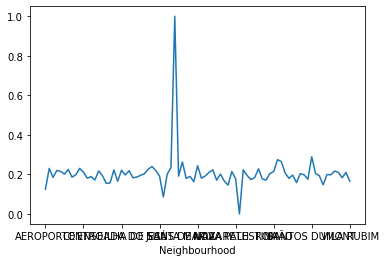

In [20]:
df_neighbour_ratio['avg'].plot()

Podemos perceber que são poucos bairros que fogem do padrão de 20% de 'não-faltantes'.

In [21]:
df_neighbour_ratio[df_neighbour_ratio['avg'] > 0.30]

,avg,count
Neighbourhood,,
ILHAS OCEÂNICAS DE TRINDADE,1.0,2


In [22]:
df_neighbour_ratio[df_neighbour_ratio['avg'] < 0.10]

,avg,count
Neighbourhood,,
ILHA DO BOI,0.085714,35
PARQUE INDUSTRIAL,0.000000,1


Concluímos, para os bairros, que os casos que fogem do intervalo de 10% a 30% de faltantes são exclusivos de baixa amostragem, ou seja, o bairro não trará grande relevância para o modelo e também poderá ser descartado.

In [23]:
df.drop(columns=['Neighbourhood'], inplace=True)

### Transformação dos Dados

Agora, iremos realizar a portabilidade dos dados de idade para intervalos de igual tamanho de 4 anos de idade.

In [24]:
df['Age'] = pd.cut(df['Age'], bins=29, precision=0)

Em seguida, preferimos portabilizar a coluna 'Handcap' (que nos dá um quantitativo numérico de quantas deficiências o paciente tem) para binário: tem ou não tem.

In [25]:
df['Handcap'] = df['Handcap'].map({1 : True, 2 : True, 3 : True, 4 : True, 0 : False})

In [26]:
print(df.sample(5))

       Gender           Age  Scholarship  Hipertension  Diabetes  Alcoholism  \
72859   False  (63.0, 67.0]        False          True      True       False   
34617   False  (28.0, 32.0]        False         False     False       False   
24872   False  (52.0, 56.0]        False         False     False       False   
26989   False   (-0.0, 4.0]        False         False     False       False   
50386   False   (-0.0, 4.0]        False         False     False       False   

       Handcap  SMS_received  No-show  ScheduleToAppointment  ScheduleWeekDay  
72859    False          True    False                   15.0                1  
34617    False          True    False                   14.0                1  
24872    False         False    False                    0.0                0  
26989    False         False    False                    0.0                3  
50386    False         False    False                   33.0                2  


Por fim, optamos por categorizar, também, a coluna que dá a distância temporal entre agendamento e consulta:

In [27]:
df['ScheduleToAppointment'] = pd.cut(df['ScheduleToAppointment'], bins=30, precision=0)

In [28]:
print(df.sample(5))

       Gender           Age  Scholarship  Hipertension  Diabetes  Alcoholism  \
2852    False  (32.0, 36.0]        False         False     False       False   
39536   False  (32.0, 36.0]        False         False     False       False   
70584    True  (20.0, 24.0]        False         False     False       False   
36245   False  (28.0, 32.0]         True         False     False       False   
7812     True  (56.0, 59.0]        False         False     False       False   

       Handcap  SMS_received  No-show ScheduleToAppointment  ScheduleWeekDay  
2852     False          True    False          (48.0, 54.0]                4  
39536    False         False     True           (-0.0, 6.0]                0  
70584    False         False    False           (-0.0, 6.0]                3  
36245    False         False     True           (-0.0, 6.0]                3  
7812     False         False    False           (-0.0, 6.0]                4  
